In [1]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [57]:
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pa.npy')
a,ale,ahe = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Plm.npy')
m,mle,mhe = Highest_density_region(px,x)

time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

In [58]:
T=[0]
M=[0]
IMB = []
for i in range(len(time)//2):
    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
    M.append(M[i] + mass)
    IMB.append(mass)
    T.append(time[i*2+1])

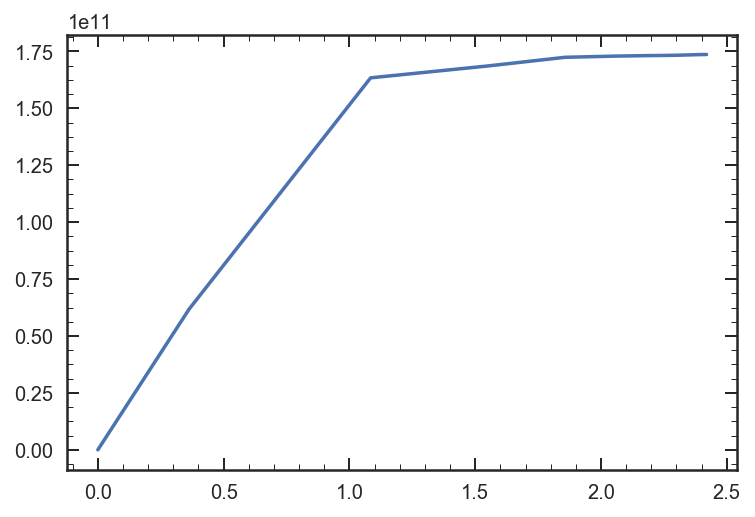

In [59]:
plt.plot(T,M / M[-1] * 10**m)

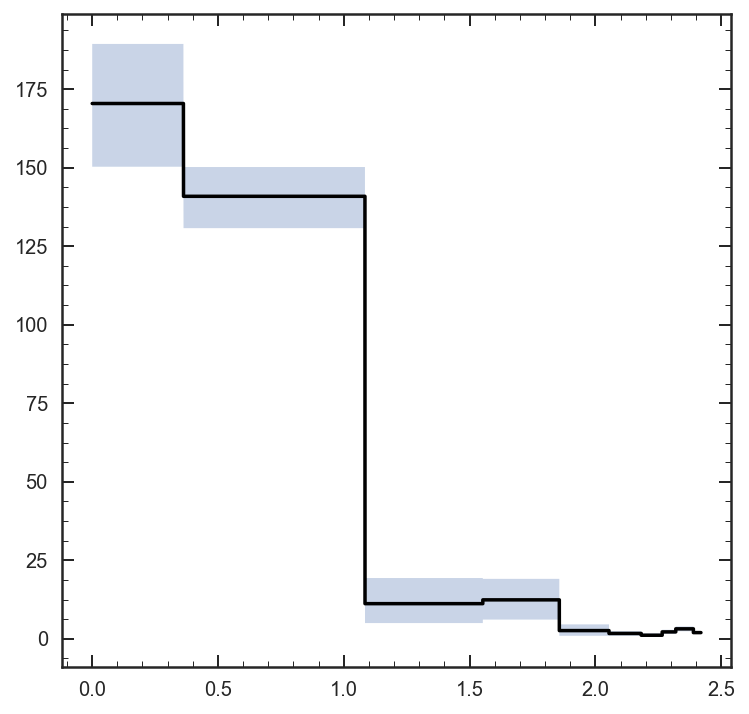

In [62]:
plt.figure(figsize=[6,6])
plt.plot(time,sfr/ M[-1] * 10**m / 1E9,'k')
# plt.plot(time,sfr_l,'k')
# plt.plot(time,sfr_h,'k')
plt.fill_between(time,sfr_l/ M[-1] * 10**m / 1E9, sfr_h/ M[-1] * 10**m / 1E9, alpha = 0.3)


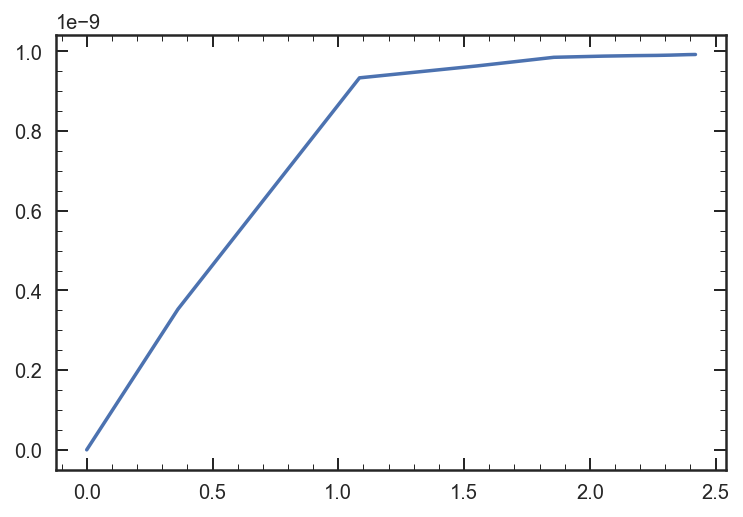

In [53]:
plt.plot(T,M)

In [75]:
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

def Gen_PPF(x,px):
    return interp1d(np.cumsum(px) / np.cumsum(px).max(),x)

def boot_to_posterior(values, weights):
    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(values, q, weights=weights)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(values, bins=bins, weights=weights,range=np.sort(span))
    n = norm_kde(n, 20.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

def Derive_SFH_weights(SFH, grid):
    Y = np.array(SFH)

    weights = np.zeros(len(grid))
    for i in range(len(grid)):
        weights[i] = np.sum((grid[i][0:len(Y)] - Y) ** 2) ** -1
    return weights

rshifts = np.arange(0,14,0.01)
age_at_z = cosmo.age(rshifts).value
age_to_z = interp1d(age_at_z, rshifts)
lbt_at_z = cosmo.lookback_time(rshifts).value
lbt_to_z = interp1d(lbt_at_z, rshifts)

class Rescale_sfh(object):
    def __init__(self, field, galaxy, trials = 1000):

        rshifts = np.arange(0,14,0.01)
        age_at_z = cosmo.age(rshifts).value
        age_to_z = interp1d(age_at_z, rshifts)

        ppf_dict = {}
        params = ['a', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'lm']

        for i in params:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(field, galaxy, i))
            ppf_dict[i] = Gen_PPF(x,px)

            idx = 0
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
            rshift = x[px == max(px)][0]
            self.fulltimes = np.arange(0.01,Oldest_galaxy(rshift),0.01)
            sfr_grid = []
            ssfr_grid = []
            t_50_grid = []
            t_q_grid = []

        while idx < trials:
            try:
                draw = np.zeros(len(params))

                for i in range(len(draw)):
                    draw[i] = ppf_dict[params[i]](np.random.rand(1))[0]

                time, sfr, tmax = convert_sfh(get_agebins(draw[0]), draw[1:11], maxage = draw[0]*1E9)

                T=[0]
                M=[0]
                for i in range(len(time)//2):
                    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
                    M.append(M[i] + mass)
                    T.append(time[i*2+1])

                sfr = sfr/ M[-1] * 10**draw[11] / 1E9

                lbt = np.abs(time - time[-1])[::-1]
                lbsfr = sfr[::-1]

                T=[0]
                M=[0]
                for i in range(len(lbt)//2):
                    mass = lbsfr[i*2+1] * (lbt[i*2+1] - lbt[i*2])
                    M.append(M[i] + mass)
                    T.append(lbt[i*2+1])

                t_50_grid.append(interp1d(M/ M[-1], T)(0.5))

                sfrmax = np.argmax(lbsfr) 

                for i in range(len(lbsfr[0:sfrmax+1])):
                    if int(lbsfr[0:sfrmax+1][-(i+1)]) <= int(max(lbsfr[0:sfrmax+1]) * 0.1):
                        t_q_grid.append(lbt[0:sfrmax+1][-(i+1)])
                        break

                sfr_grid.append(interp1d(lbt,lbsfr,bounds_error=False,fill_value=0)(self.fulltimes))

                ssfr_grid.append(lbsfr[0] / 10**draw[11])
                idx +=1
            except:
                pass

        SFH = []
        SFH_16 = []
        SFH_84 = []
        ftimes = []
        for i in range(len(np.array(sfr_grid).T)):
            adat = np.array(np.array(sfr_grid).T[i])
            gdat = adat[adat>0]
            if len(gdat) < trials * 0.1:
                break
            else:
                SFH.append(np.percentile(gdat,50))
                SFH_16.append(np.percentile(gdat,16))
                SFH_84.append(np.percentile(gdat,84))

                ftimes.append(self.fulltimes[i])

        self.SFH = np.array(SFH)
        self.SFH_16 = np.array(SFH_16)
        self.SFH_84 = np.array(SFH_84)
        self.LBT = np.array(ftimes)
        
        self.sfr_grid = np.ma.masked_less_equal(sfr_grid,1E-10)

        weights = Derive_SFH_weights(self.SFH, sfr_grid[0:trials])
       
        x,y = boot_to_posterior(t_50_grid[0:trials], weights)
        self.t_50,t_50_l,t_50_h = Highest_density_region(y,x)
        self.t_50_16 = self.t_50 - t_50_l
        self.t_50_84 = self.t_50 + t_50_h

        x,y = boot_to_posterior(t_q_grid[0:trials], weights)
        self.t_q,t_q_l,t_q_h = Highest_density_region(y,x)
        self.t_q_16 = self.t_q - t_q_l
        self.t_q_84 = self.t_q + t_q_h  

        self.z_50 = age_to_z(Oldest_galaxy(rshift) - self.t_50)
        self.z_50_16 = age_to_z(Oldest_galaxy(rshift) - self.t_50_16)
        self.z_50_84 = age_to_z(Oldest_galaxy(rshift) - self.t_50_84)

        self.z_q = age_to_z(Oldest_galaxy(rshift) - self.t_q)
        self.z_q_16 = age_to_z(Oldest_galaxy(rshift) - self.t_q_16)
        self.z_q_84 = age_to_z(Oldest_galaxy(rshift) - self.t_q_84)

        x,y = boot_to_posterior(np.log10(ssfr_grid[0:trials]), weights)
        self.lssfr,lssfr_l,lssfr_h = Highest_density_region(y,x)
        self.lssfr_16 = self.lssfr - lssfr_l
        self.lssfr_84 = self.lssfr + lssfr_h     

In [41]:
tfits = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

In [19]:
tfits

,Av,Av_16,Av_84,Z,Z_16,Z_84,lmass,lmass_16,lmass_84,lwa,...,zgrism_84,field,id,z_50,z_q,t_50,t_q,log_ssfr,Reff,compact
0,0.27072,0.17000,0.35859,0.75357,0.64281,0.86850,10.79707,10.77101,10.82145,1.41730,...,1.01816,GND,12078,1.931392,1.041807,1.595974,3.895963,-13.076292,1.990141,e
1,0.13549,0.03675,0.22822,1.41771,0.71921,1.57754,10.86442,10.83734,10.88442,2.71107,...,0.95668,GND,12793,2.589244,1.185956,1.773904,4.429514,-11.419689,2.563662,e
2,0.17152,0.11533,0.24103,0.89462,0.65043,0.96473,10.46598,10.43968,10.50487,2.71486,...,0.97020,GND,13182,2.655225,2.432847,0.343755,0.582334,-14.090606,2.732839,e
3,0.00507,0.00117,0.00925,0.99176,0.91223,1.09813,11.01559,10.98819,11.03816,3.63991,...,0.85006,GND,13774,2.589881,2.319427,0.344520,0.653454,-14.892121,1.776227,c
4,0.00147,0.00147,0.01744,0.82400,0.75427,1.04179,10.57585,10.50344,10.59692,1.99219,...,0.91549,GND,14158,1.724475,1.191710,0.843199,2.223632,-11.414106,2.908993,e
5,0.00225,0.00225,0.01991,1.30184,1.22779,1.44317,10.78714,10.77329,10.79991,2.76391,...,1.23195,GND,14713,3.260863,2.940693,0.261780,0.502510,-11.342902,1.514090,e
6,0.00201,0.00201,0.05309,1.16452,0.93019,1.39456,10.25492,10.20660,10.28166,2.22912,...,1.04464,GND,15901,3.682792,2.101266,1.410045,2.838986,-11.295009,2.089374,e
7,0.56370,0.51172,0.62226,0.64298,0.51836,0.79938,10.97864,10.93431,11.01231,2.44959,...,1.01764,GND,16758,2.176696,1.621376,0.655157,1.630860,-11.584418,1.454512,c
8,0.00155,0.00155,0.16757,0.99734,0.81624,1.05773,11.15457,11.12469,11.17946,2.95779,...,1.24230,GND,17070,4.260855,2.425442,0.997677,2.272262,-12.015797,0.827498,c
9,0.00146,0.00146,0.05214,0.77024,0.66046,1.03456,10.33242,10.29839,10.35665,2.23322,...,0.91326,GND,17436,1.934199,1.472604,0.795936,1.749872,-11.753820,1.092665,c


In [235]:
sfh = Rescale_sfh('GSD',39170, trials=1000)

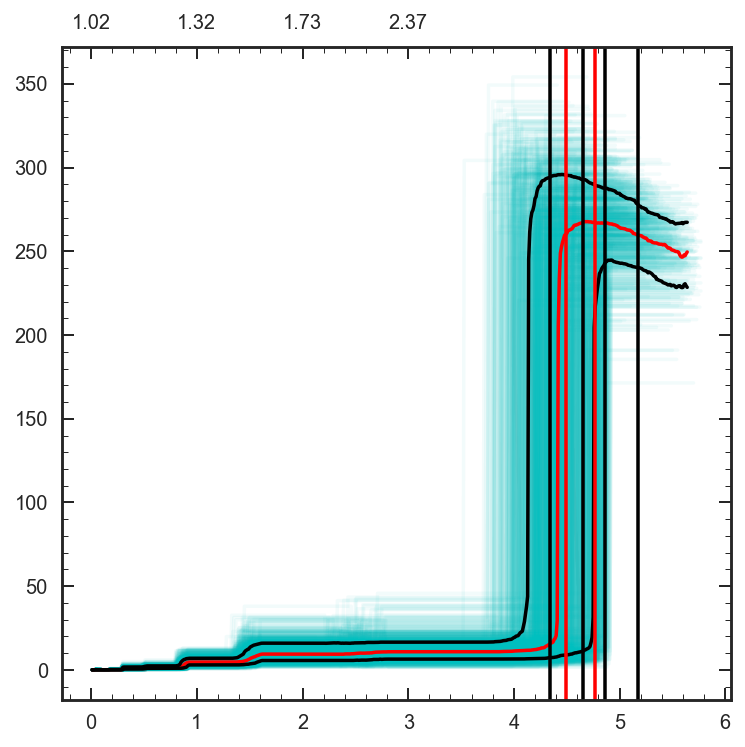

In [236]:
fig = plt.figure(figsize=[6,6])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(sfh.fulltimes, sfh.sfr_grid.T, 'c', alpha=0.05)
ax1.plot(sfh.LBT,sfh.SFH , 'r')
ax1.plot(sfh.LBT,sfh.SFH_16, 'k')
ax1.plot(sfh.LBT,sfh.SFH_84, 'k')

ax1.axvline(sfh.t_50, color = 'r')
ax1.axvline(sfh.t_50_16, color = 'k')
ax1.axvline(sfh.t_50_84, color = 'k')

ax1.axvline(sfh.t_q, color = 'r')
ax1.axvline(sfh.t_q_16, color = 'k')
ax1.axvline(sfh.t_q_84, color = 'k')

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(np.arange(0,4))
ax2.set_xticklabels( np.round(lbt_to_z(np.arange(0,4) + cosmo.lookback_time(1.023).value),2))
ax2.xaxis.set_ticks_position('top')



In [220]:
print(sfh.z_q, sfh.lssfr, sfh.z_50, sfh.t_50)

3.094944215596254 -11.590147159379901 5.904124852437825 1.6844299321002418


In [221]:
print(sfh.z_q_16, sfh.z_q, sfh.z_q_84)
print(sfh.t_q_16, sfh.t_q, sfh.t_q_84)
print(sfh.lssfr_16, sfh.lssfr, sfh.lssfr_84)

2.869127341819112 3.094944215596254 3.282045485787646
0.3778076369114199 0.5600887645044574 0.6934570874846611
-11.91638850796604 -11.590147159379901 -11.184575087773943


In [215]:
tfits.query('zgrism > 2')

,Av,Av_16,Av_84,Z,Z_16,Z_84,lmass,lmass_16,lmass_84,lwa,...,zgrism_84,field,id,z_50,z_q,t_50,t_q,log_ssfr,Reff,compact
81,0.00234,0.00234,0.05315,1.45230,1.35667,1.57737,11.01935,10.99433,11.04631,1.30835,...,2.03279,GND,14132,3.980914,2.275565,0.779507,2.116622,-11.334102,1.334125,e
94,0.06852,0.04382,0.22011,1.19217,0.96893,1.34744,11.19105,11.13789,11.22793,1.60217,...,2.09910,GND,21738,6.275254,4.092550,0.819008,1.439531,-13.778602,1.219869,c
100,0.34622,0.22494,0.47330,1.31507,0.89793,1.57743,11.08409,11.06043,11.10652,0.99000,...,2.01453,GND,22774,3.613101,2.259021,0.802674,1.973410,-13.394358,3.469714,e
101,0.06787,0.04743,0.09497,1.04527,0.97827,1.12052,11.24472,11.20810,11.27056,1.60324,...,2.31894,GND,23018,7.173639,4.059418,0.312678,1.088821,-10.750475,3.060592,e
108,0.00182,0.00182,0.28905,1.57746,1.09329,1.57746,11.08183,11.06669,11.12442,1.41052,...,2.49368,GND,28890,5.909145,3.095848,0.719060,1.843757,-11.618151,3.037426,e
113,0.35804,0.26015,0.46811,1.07195,0.56376,1.16100,10.71397,10.68454,10.74758,1.01659,...,2.14993,GND,32933,3.620963,2.298854,0.730708,1.854338,-10.222148,1.498688,e
153,0.31048,0.19540,0.42658,1.39791,1.27377,1.57745,11.05431,11.02258,11.09243,1.49145,...,2.09096,GSD,43572,5.127033,2.554038,0.932369,2.355124,-11.256607,3.737658,e
157,0.55389,0.47940,0.78689,0.30716,0.17717,0.60690,10.73267,10.68022,10.75899,0.65664,...,2.41633,GSD,46072,5.880970,3.440709,0.793404,1.677208,-9.947261,5.988517,e
163,0.33777,0.29828,0.40151,1.26998,1.14041,1.42914,11.22457,11.20626,11.24867,1.11358,...,2.35631,GSD,48464,4.554230,2.669233,0.742274,1.867143,-10.703025,2.663837,e


In [217]:
tfits.query('id == 28890').zgrism


108    2.48489
Name: zgrism, dtype: float64

In [2]:
plt.figure(figsize = [10,10])
for i in range(len(fld)):
    med = np.zeros(10)
    for ii in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(fld[i], ids[i], ii+1))
        med[ii] = x[px == px.max()][0]

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(fld[i], ids[i]))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    plt.plot(time,sfr)
plt.xlabel('t$_{star-formation}$ (Gyr)', fontsize=20)
plt.ylabel('SFR', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/all_sfr.png' ,bbox_inches = 'tight')


NameError: name 'fld' is not defined

<Figure size 720x720 with 0 Axes>

(10,)

# get size

In [74]:
morph_db.to_pickle('../dataframes/morphology.pkl')
SF_db.to_pickle('../Casey_data/SF_db.pkl')

In [11]:
morph_db = pd.DataFrame({'id' : select.id.values, 'field' : select.field.values, 'Rpc' : Rpc, 'lm' : lm, 'lml' : lml, 'lmh' : lmh, 'z' : rs,
                         'zl' : rsl, 'zh' :  rsh, 'lwa' : lwa, 'lwal' : lwal, 'lwah' : lwah, 'Reff' : Reff, 'AGN' : select.AGN.values})

In [15]:
morph_db = morph_db[[ 'field', 'id', 'Rpc', 'lm', 'lml', 'lmh', 'z','zl', 'zh', 'lwa', 'lwal', 'lwah', 'Reff', 'AGN']]

In [31]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

In [34]:
mdb = morph_db.query('Reff > 0')

In [4]:
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')

In [21]:
inout = []

for i in mdb.index:
    for ii in range(len(mdb.zgrism_hci[i])//2):
        if mdb.zgrism_hci[i][2*ii] <= mdb.zgrism[i] <= mdb.zgrism_hci[i][2*ii+1]:
            if(mdb.zgrism_hci[i][2*ii+1] - mdb.zgrism_hci[i][2*ii]) /( 2 * (1 + mdb.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        

mdb['inout'] = inout

mdb = mdb.query('inout == "i"')

In [26]:
SF_db = pd.read_pickle('../Casey_data/SF_db.pkl')

sfdb = SF_db.query('AGN != "AGN" and Z > 0')


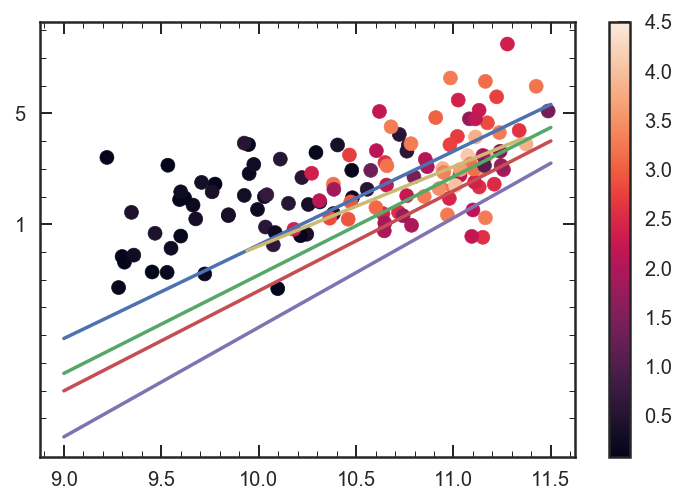

In [82]:
plt.scatter(np.append(sfdb.lmass,mdb.lm), np.log10(np.append(sfdb.Reff,mdb.Rpc)), 
            c = np.append(sfdb.lwa,mdb.lwa))

masses = np.linspace(9,11.5)
lrh1 = 0.46 + 0.59*(masses - 11)
lrh2 = 0.30 + 0.62*(masses - 11)
lrh3 = 0.21 + 0.63*(masses - 11)
lrh4 = 0.04 + 0.69*(masses - 11)

plt.plot(masses,lrh1)
plt.plot(masses,lrh2)
plt.plot(masses,lrh3)
plt.plot(masses,lrh4)

plt.yticks([np.log10(1),np.log10(5)],[1,5])
plt.plot([9.94,11.35], np.log10([0.68, 3.45]))
plt.colorbar()

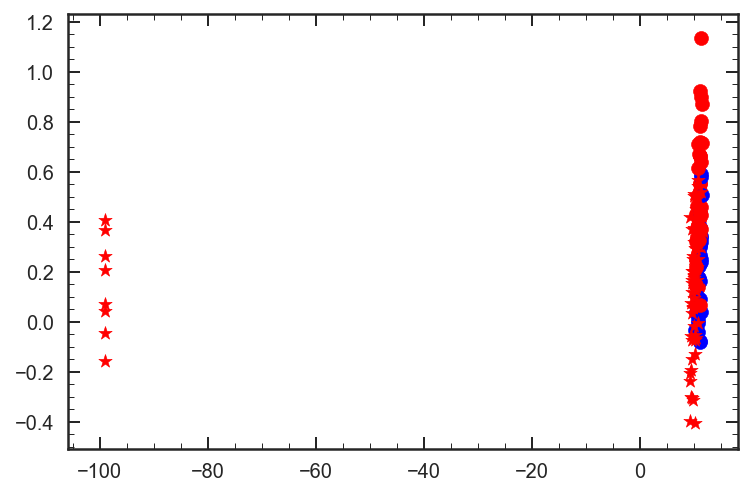

In [73]:
gamma = [0.46, 0.3, 0.21, 0.04]
beta = [0.59, 0.62, 0.63, 0.69]

masses = np.linspace(9,11.5)
compactness =[]

for i in morph_db.index:
    if 0.4 < morph_db.z[i] < 1.0:
        idx = 0
    if 1.0 < morph_db.z[i] < 1.5:
        idx = 1
    if 1.5 < morph_db.z[i] < 2.0:
        idx = 2
    if 2.0 < morph_db.z[i] < 2.5:
        idx = 3
    if np.log10(morph_db.Rpc[i]) >  gamma[idx] + beta[idx]*(morph_db.lm[i] - 11):
        plt.scatter(morph_db.lm[i], np.log10(morph_db.Rpc[i]), color = 'r')
        compactness.append('e')
    else:
        plt.scatter(morph_db.lm[i], np.log10(morph_db.Rpc[i]), color = 'b')
        compactness.append('c')
morph_db['compact'] = compactness
compactness =[]
for i in SF_db.index:
    if 0.4 < SF_db.z[i] < 1.0:
        idx = 0
    if 1.0 < SF_db.z[i] < 1.5:
        idx = 1
    if 1.5 < SF_db.z[i] < 2.0:
        idx = 2
    if 2.0 < SF_db.z[i] < 2.5:
        idx = 3
    if np.log10(SF_db.Reff[i]) >  gamma[idx] + beta[idx]*(SF_db.lmass[i] - 11):
        plt.scatter(SF_db.lmass[i], np.log10(SF_db.Reff[i]), marker = '*',color = 'r')
        compactness.append('e')
    else:
        plt.scatter(SF_db.lmass[i], np.log10(SF_db.Reff[i]), marker = '*', color = 'b')
        compactness.append('c')
SF_db['compact'] = compactness
        

# plt.plot(masses,lrh1)
# plt.plot(masses,lrh2)
# plt.plot(masses,lrh3)
# plt.plot(masses,lrh4)

# plt.yticks([np.log10(1),np.log10(5)],[1,5])
# plt.plot([9.94,11.35], np.log10([0.68, 3.45]))
# plt.colorbar()

In [21]:
compactness =[]
for i in range(len(lm)):
    if np.log10(Rpc[i]) > m*lm[i] - 5.14:
        compactness.append('e')
    else:
        compactness.append('c')

In [22]:
morph_db['compact'] = compactness

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


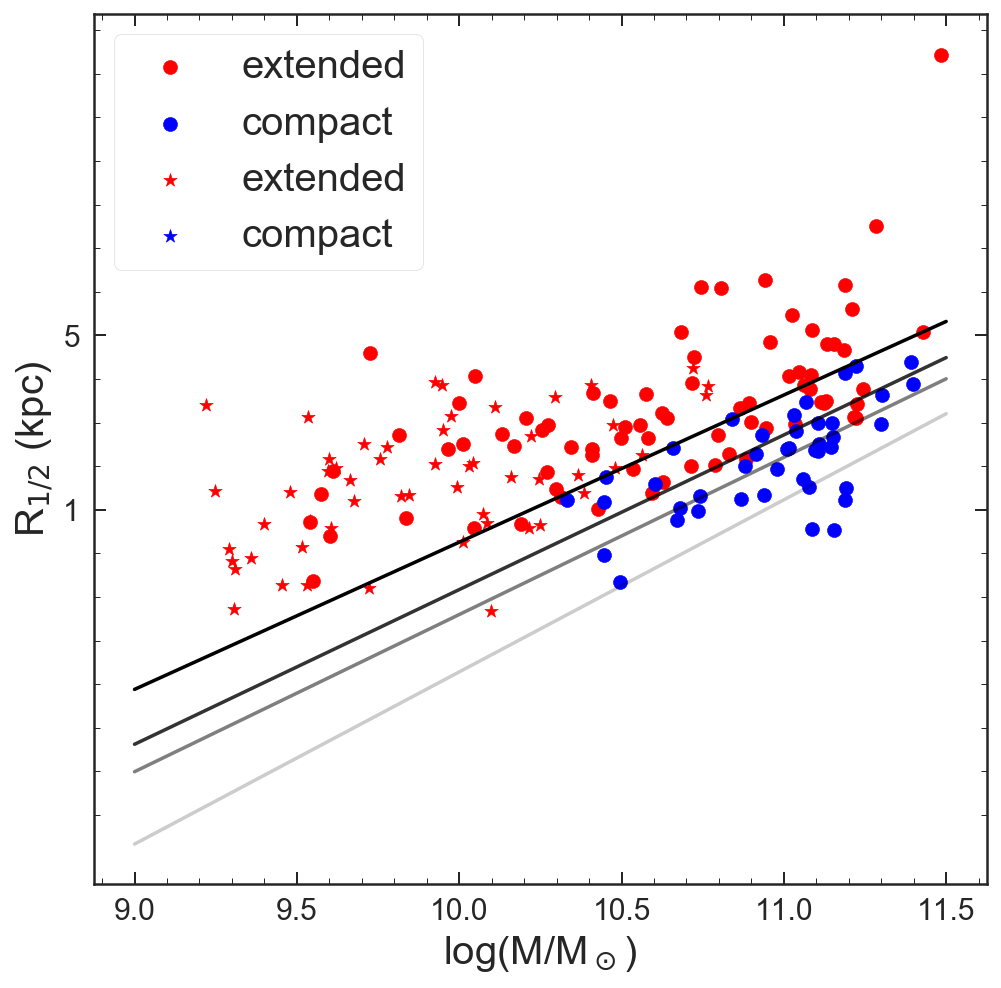

In [27]:
m = (np.log10(3.45) - np.log10(0.68)) / (11.35 -  9.94)
 
    
plt.figure(figsize=[8,8])
plt.scatter(mdb.query('compact == "e"').lmass,np.log10(mdb.query('compact == "e"').Reff), color = 'r', label = 'extended')
plt.scatter(mdb.query('compact == "c"').lmass,np.log10(mdb.query('compact == "c"').Reff), color = 'b', label = 'compact')
        
plt.scatter(sfdb.query('compact == "e"').lmass,np.log10(sfdb.query('compact == "e"').Reff),marker='*', color = 'r', label = 'extended')
plt.scatter(sfdb.query('compact == "c"').lmass,np.log10(sfdb.query('compact == "c"').Reff), marker='*', color = 'b', label = 'compact')
    
plt.yticks([np.log10(1),np.log10(5)],[1,5])

masses = np.linspace(9,11.5)
lrh1 = 0.46 + 0.59*(masses - 11)
lrh2 = 0.30 + 0.62*(masses - 11)
lrh3 = 0.21 + 0.63*(masses - 11)
lrh4 = 0.04 + 0.69*(masses - 11)

plt.plot(masses,lrh1, 'k', alpha = 1)
plt.plot(masses,lrh2, 'k', alpha = 0.8)
plt.plot(masses,lrh3, 'k', alpha = 0.5)
plt.plot(masses,lrh4, 'k', alpha = 0.2)


plt.ylabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.xlabel('log(M/M$_\odot$)', fontsize=20)
plt.legend(fontsize =20, frameon = True)
plt.tick_params(axis='both', which='major', labelsize=15)
# plt.savefig('../plots/morph/r_lm.png', bbox_inches = 'tight')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(0, 8)

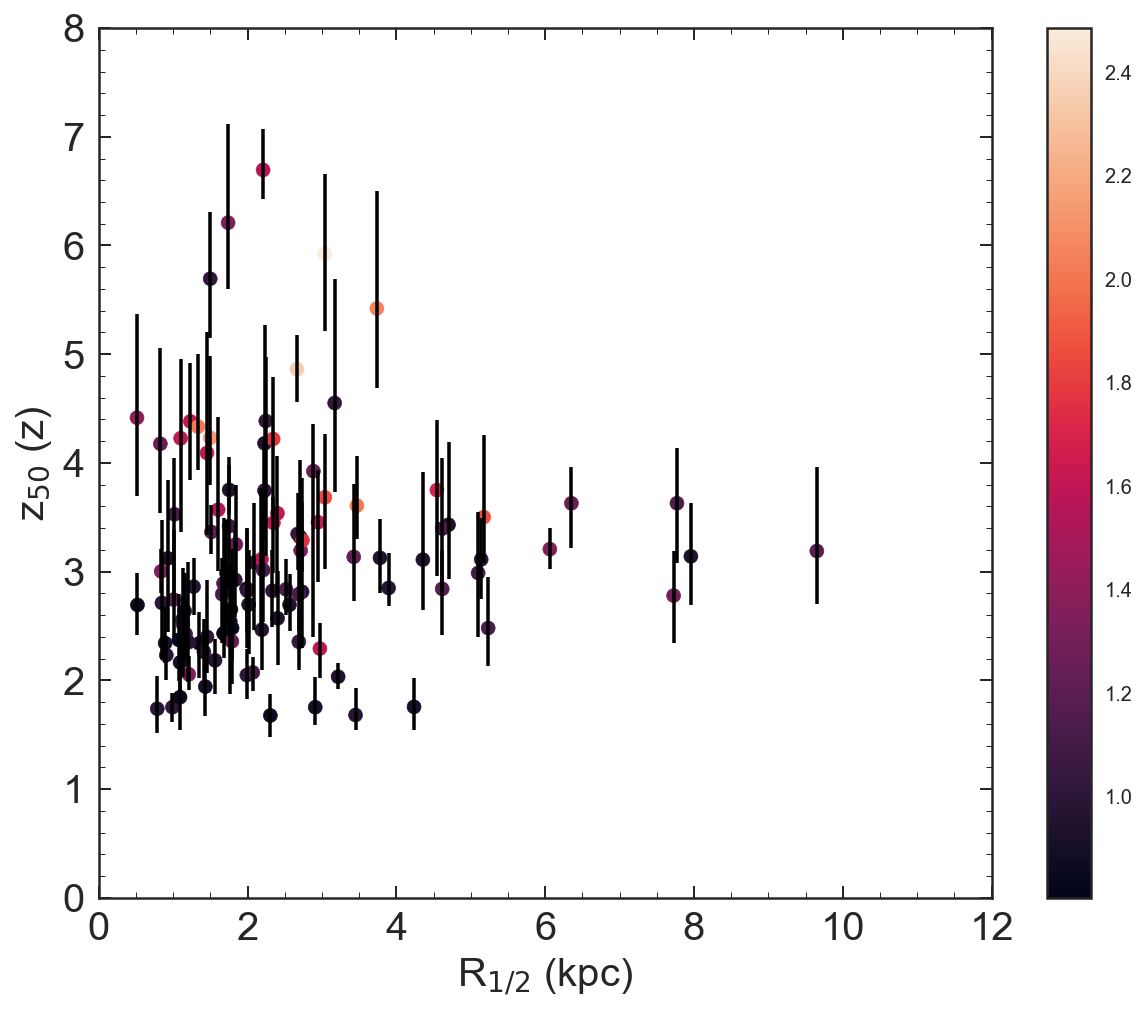

In [67]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')
# mdb = morph_db.query('1.8 < zgrism < 2.2 and log_ssfr  > -15')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            if (mdb.z_50_hci[i][2*ii+1] - mdb.z_50_hci[i][2*ii]) /2  < 1:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

plt.figure(figsize=[10,8])

for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            plt.errorbar(mdb.Reff[i],mdb.z_50[i], 
                 yerr=[[mdb.z_50[i] - mdb.z_50_hci[i][2*ii]], [mdb.z_50_hci[i][2*ii+1] - mdb.z_50[i]]], fmt='ko',
                        markersize=1)
plt.scatter(mdb.Reff, mdb.z_50, marker='o', c = mdb.zgrism)

# plt.hexbin(mdb.Reff, mdb.z_50, cmap = cmap)
# plt.scatter(sfdb.Reff,sfdb.z50, marker = '*',c = sfdb.log_ssfr, s =100)
plt.colorbar()

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('z$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,12)
plt.ylim(0,8)
# plt.savefig('../plots/morph/z_50_r.png', bbox_inches = 'tight')

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


(0, 6)

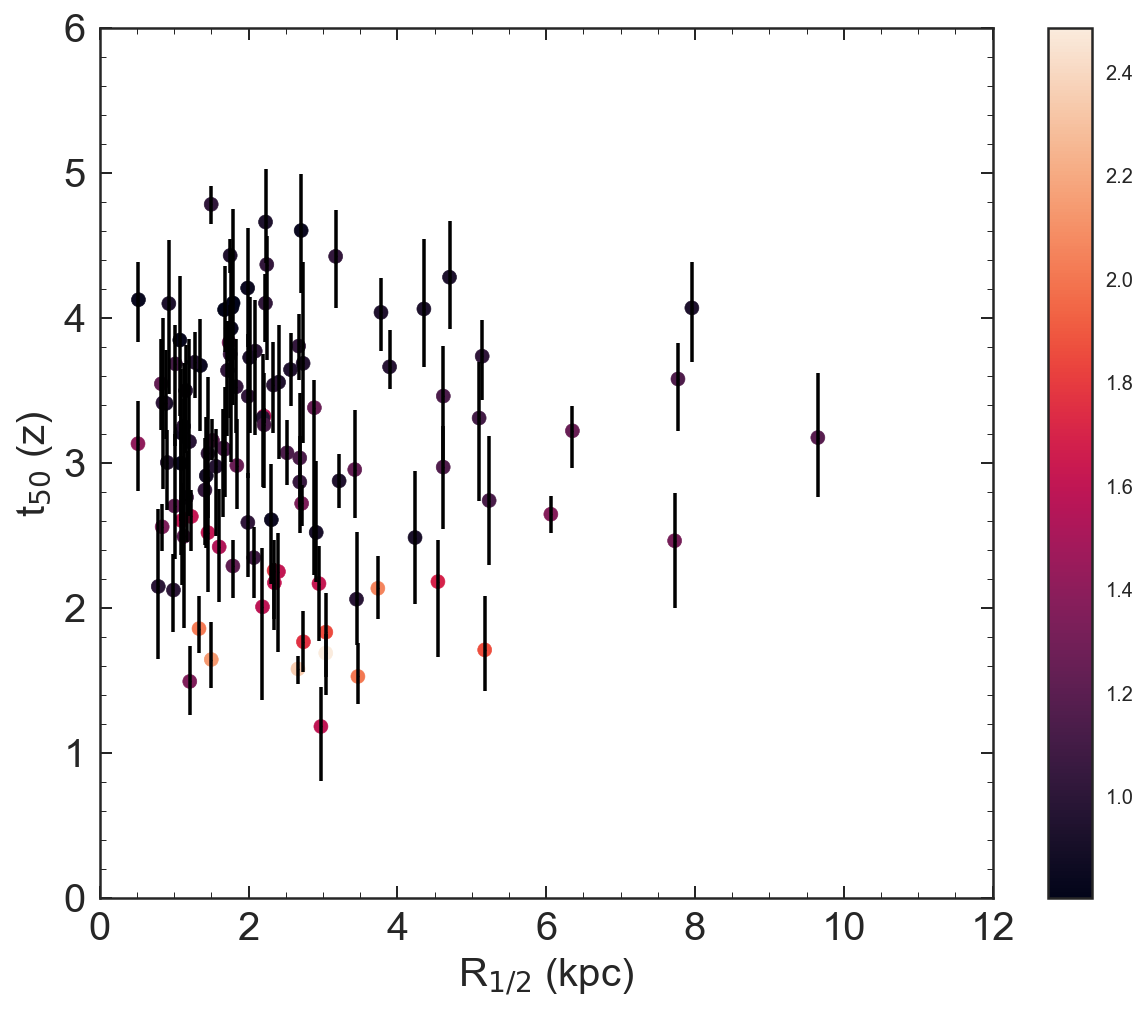

In [63]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')
mdb = morph_db.query('zgrism > 0.8 and log_ssfr  > -15')

inout = []
for i in mdb.index:
    for ii in range(len(mdb.z_50_hci[i])//2):
        if mdb.z_50_hci[i][2*ii] <= mdb.z_50[i] <= mdb.z_50_hci[i][2*ii+1]:
            if (mdb.z_50_hci[i][2*ii+1] - mdb.z_50_hci[i][2*ii]) /2  < 1:
                inout.append('i')
            else:
                inout.append('o')
        
mdb['inout'] = inout
mdb = mdb.query('inout == "i"')

plt.figure(figsize=[10,8])

for i in mdb.index:
    for ii in range(len(mdb.t_50_hci[i])//2):
        if mdb.t_50_hci[i][2*ii] <= mdb.t_50[i] <= mdb.t_50_hci[i][2*ii+1]:
            plt.errorbar(mdb.Reff[i],mdb.t_50[i], 
                 yerr=[[mdb.t_50[i] - mdb.t_50_hci[i][2*ii]], [mdb.t_50_hci[i][2*ii+1] - mdb.t_50[i]]], fmt='ko',
                        markersize=1)
plt.scatter(mdb.Reff, mdb.t_50, marker='o', c = mdb.zgrism)

# plt.hexbin(mdb.Reff, mdb.z_50, cmap = cmap)
# plt.scatter(sfdb.Reff,sfdb.z50, marker = '*',c = sfdb.log_ssfr, s =100)
plt.colorbar()

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('t$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xlim(0,12)
plt.ylim(0,6)
# plt.savefig('../plots/morph/z_50_r.png', bbox_inches = 'tight')

(0, 6)

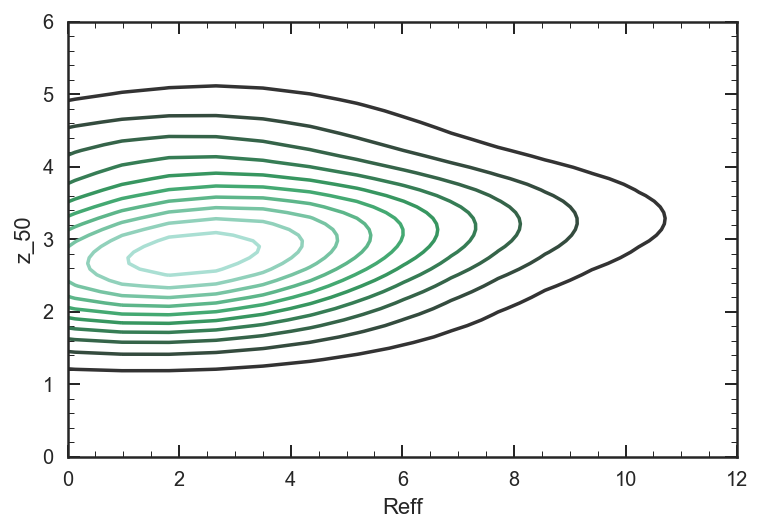

In [58]:
sea.kdeplot(mdb.Reff, mdb.z_50)
plt.xlim(0,12)
plt.ylim(0,6)


In [47]:
def Leave_one_out(dist, x):
    Y = np.zeros(x.size)
    for i in range(len(dist)):
        Y += dist[i]
    Y /= np.trapz(Y, x)

    w = np.arange(.01, 2.01, .01)
    weights = np.zeros(len(dist))
    for i in range(len(dist)):
        Ybar = np.zeros(x.size)
        for ii in range(len(dist)):
            if i != ii:
                Ybar += dist[ii]
        Ybar /= np.trapz(Ybar, x)
        weights[i] = np.sum((Ybar - Y) ** 2) ** -1
    return weights

def Stack_posteriors(P_grid, x):
    P_grid = np.array(P_grid)
    W = Leave_one_out(P_grid,x)
    top = np.zeros(P_grid.shape)
    for i in range(W.size):
        top[i] = W[i] * P_grid[i]
    P =sum(top)/sum(W)
    return P / np.trapz(P,x)

def Iterative_stacking(grid_o,x_o, extend=False, iterations = 20,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]
    rto = int(np.abs(min(np.log10(x_o)[np.abs(np.log10(x_o)) != np.inf])))+1

    if extend:
        x_n,grid_n = Reconfigure_dist(grid_o,x_o,rto)

        x = np.linspace(x_n[0],x_n[-1],resampling)
        grid = np.zeros([len(grid_n),x.size])    
        for i in range(len(grid_n)):
            grid[i] = interp1d(x_n,grid_n[i])(x)
        ### select bandwidth
        H = ksmooth.dpik(x_o) 
    else:
        x = np.linspace(x_o[0],x_o[-1],resampling)
        grid = np.zeros([len(grid_o),x.size])    
        for i in range(len(grid_o)):
            grid[i] = interp1d(x_o,grid_o[i],fill_value=0, bounds_error=False)(x)

        ### select bandwidth
        H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    rsFx = interp1d(x,Fx)(x_o)
    rsFx = rsFx/np.trapz(rsFx,x_o)  
    
    rsstkpos = interp1d(x,stkpos)(x_o)
    rsstkpos = rsstkpos/np.trapz(rsstkpos,x_o)  
    return rsFx,rsstkpos

In [91]:
def Gen_grid_lwa(DB):
    grid=[]
    all_age = np.arange(0,7 + 0.01,0.01)
    
    for i in DB.index:
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(DB.field[i], DB.id[i]))
        z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(DB.field[i], DB.id[i]))

        grid.append(interp1d(Oldest_galaxy(z[pz == max(pz)][0]) - x,px, fill_value=0, bounds_error=False)(all_age))
    return np.array(grid)

def Gen_grid(DB, param):
    all_age = np.arange(0,7 + 0.01,0.01)
    grid = np.zeros([len(DB), len(all_age)])

    for i in range(len(DB.index)):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(DB.field[DB.index[i]],DB.id[DB.index[i]], param))
        grid[i] = interp1d(x,px, fill_value=0, bounds_error=False)(all_age)
    return grid

all_age = np.arange(0,7 + 0.01,0.01)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


skip
skip
skip
skip
skip
skip


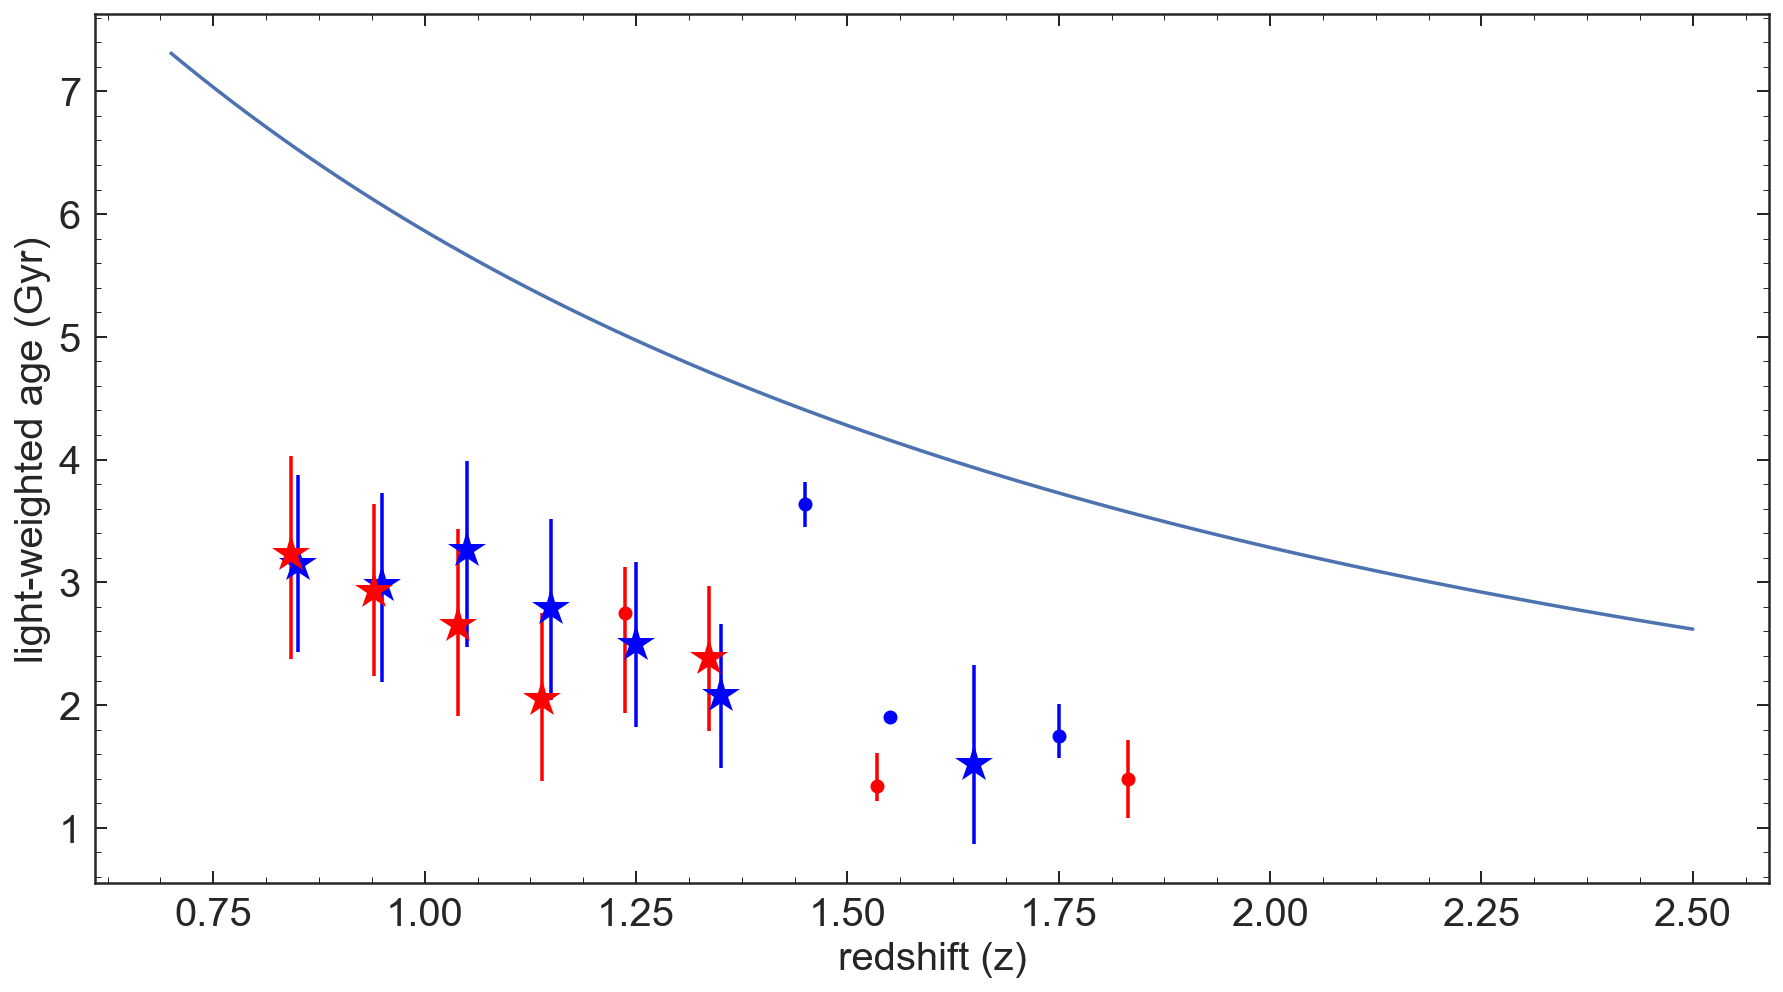

In [107]:
z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

zranges = np.arange(0.8, 2.1, 0.1 )

for i in range(len(zranges)-1):
    IDm = []
    for ii in mdb.index:       
        if zranges[i] <= mdb.z[ii] <= zranges[i+1] and mdb.compact[ii] == 'c':
            IDm.append(ii)

    if len(IDm) > 1:
        P_m = Gen_grid(mdb.query('{0} <= z <= {1} and compact == "c"'.format(zranges[i], zranges[i+1])), 'lwa')
        Pm,Pmx = Iterative_stacking(P_m,all_age)
        m,ml,mh = Highest_density_region(Pm, all_age)
        plt.errorbar((zranges[i] + zranges[i+1])/2, m, yerr=[[ml],[mh]], fmt='*', color = 'b', markersize=20)

    else:
        try:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(mdb.field[IDm[0]],mdb.id[IDm[0]]))
            m,ml,mh =Highest_density_region(px,x)
            plt.errorbar((zranges[i] + zranges[i+1])/2, m, yerr=[[ml],[mh]], fmt='o', color = 'b')
        except:
            print('skip')
###################
    IDm = []
    for ii in mdb.index:       
        if zranges[i] <= mdb.z[ii] <= zranges[i+1] and mdb.compact[ii] == 'e':
            IDm.append(ii)
    
    if len(IDm) > 1:
        P_m = Gen_grid(mdb.query('{0} <= z <= {1} and compact == "e"'.format(zranges[i], zranges[i+1])), 'lwa')
        Pm,Pmx = Iterative_stacking(P_m,all_age)
        m,ml,mh = Highest_density_region(Pm, all_age)
        plt.errorbar((zranges[i] + zranges[i+1])/2 * 0.99, m, yerr=[[ml],[mh]], fmt='*', color = 'r', markersize=20)
        
    else:
        try:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(mdb.field[IDm[0]],mdb.id[IDm[0]]))
            m,ml,mh =Highest_density_region(px,x)
            plt.errorbar((zranges[i] + zranges[i+1])/2 * 0.99, m, yerr=[[ml],[mh]], fmt='o', color = 'r')
        
        except:
            print('skip')

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/com_exp_lwa.png' ,bbox_inches = 'tight')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


skip
skip
skip
skip
skip
skip
skip
skip


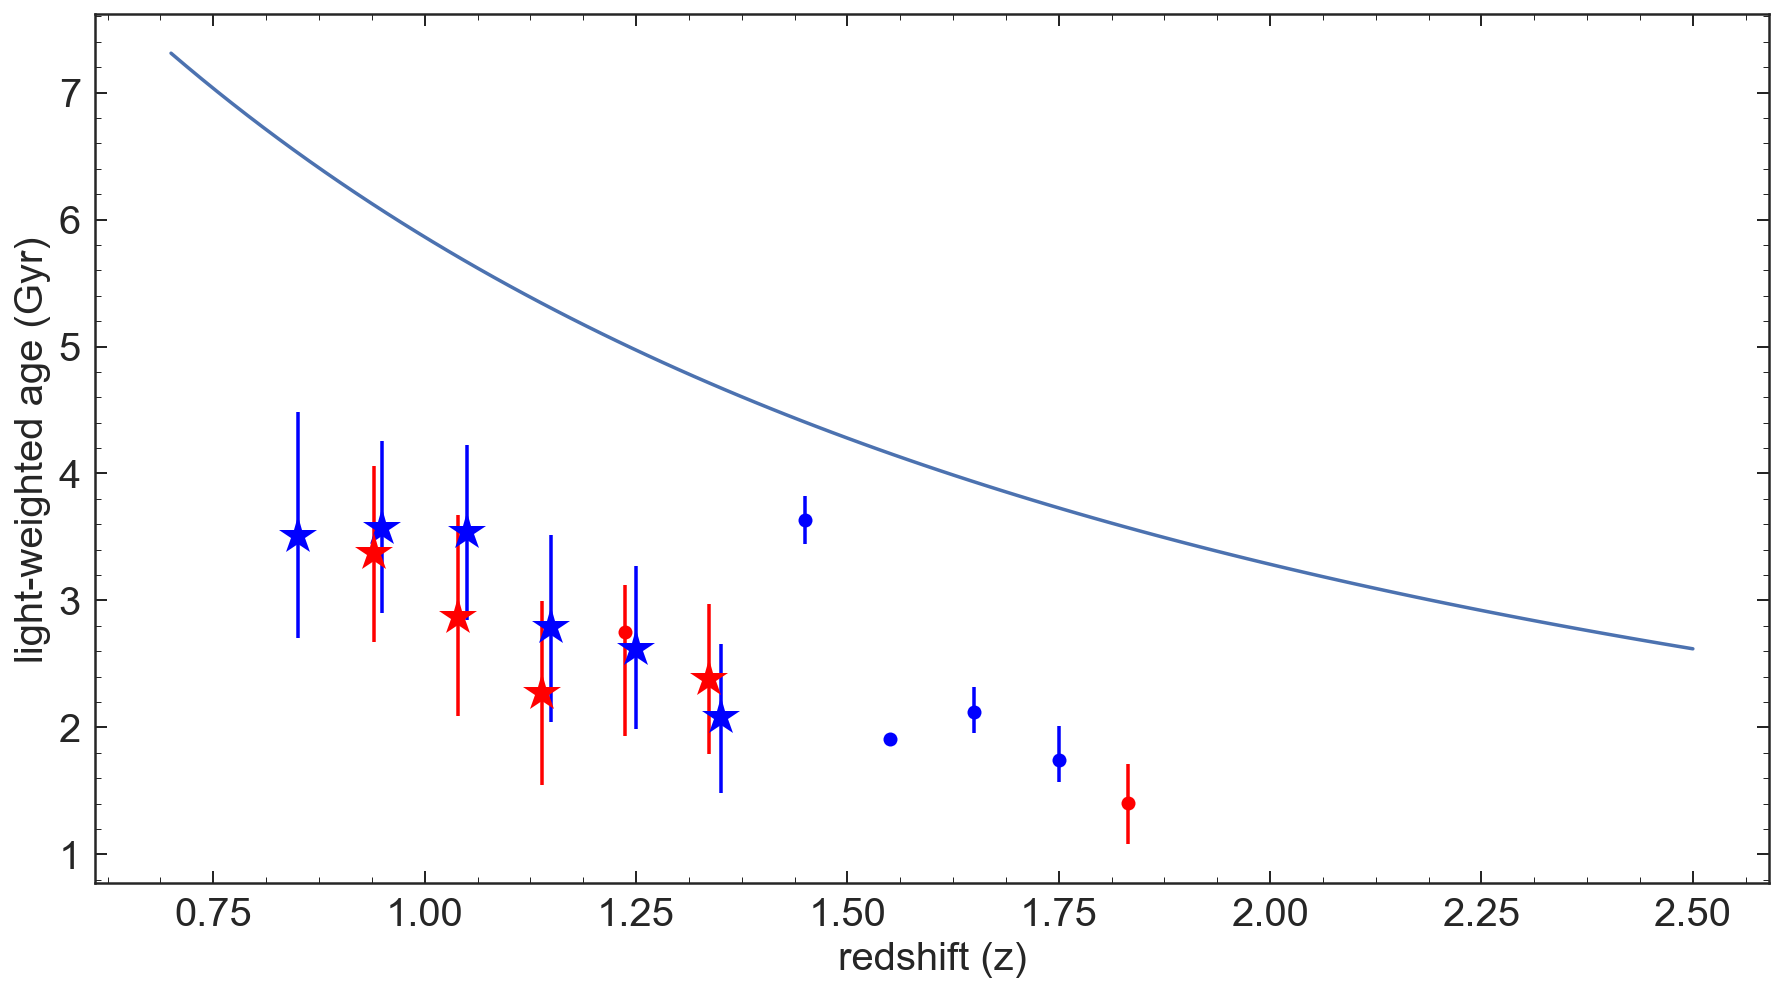

In [106]:
z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

zranges = np.arange(0.8, 2.1, 0.1 )

for i in range(len(zranges)-1):
    IDm = []
    for ii in mdb.index:       
        if zranges[i] <= mdb.z[ii] <= zranges[i+1] and mdb.compact[ii] == 'c' and mdb.z_50[ii] > 3:
            IDm.append(ii)

    if len(IDm) > 1:
        P_m = Gen_grid(mdb.query('{0} <= z <= {1} and compact == "c" and z_50 > 3'.format(zranges[i], zranges[i+1])), 'lwa')
        Pm,Pmx = Iterative_stacking(P_m,all_age)
        m,ml,mh = Highest_density_region(Pm, all_age)
        plt.errorbar((zranges[i] + zranges[i+1])/2, m, yerr=[[ml],[mh]], fmt='*', color = 'b', markersize=20)

    else:
        try:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(mdb.field[IDm[0]],mdb.id[IDm[0]]))
            m,ml,mh =Highest_density_region(px,x)
            plt.errorbar((zranges[i] + zranges[i+1])/2, m, yerr=[[ml],[mh]], fmt='o', color = 'b')
        except:
            print('skip')
###################
    IDm = []
    for ii in mdb.index:       
        if zranges[i] <= mdb.z[ii] <= zranges[i+1] and mdb.compact[ii] == 'e' and mdb.z_50[ii] > 3:
            IDm.append(ii)
    
    if len(IDm) > 1:
        P_m = Gen_grid(mdb.query('{0} <= z <= {1} and compact == "e" and z_50 > 3'.format(zranges[i], zranges[i+1])), 'lwa')
        Pm,Pmx = Iterative_stacking(P_m,all_age)
        m,ml,mh = Highest_density_region(Pm, all_age)
        plt.errorbar((zranges[i] + zranges[i+1])/2 * 0.99, m, yerr=[[ml],[mh]], fmt='*', color = 'r', markersize=20)
        
    else:
        try:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(mdb.field[IDm[0]],mdb.id[IDm[0]]))
            m,ml,mh =Highest_density_region(px,x)
            plt.errorbar((zranges[i] + zranges[i+1])/2 * 0.99, m, yerr=[[ml],[mh]], fmt='o', color = 'r')
        
        except:
            print('skip')

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/com_exp_lwa.png' ,bbox_inches = 'tight')


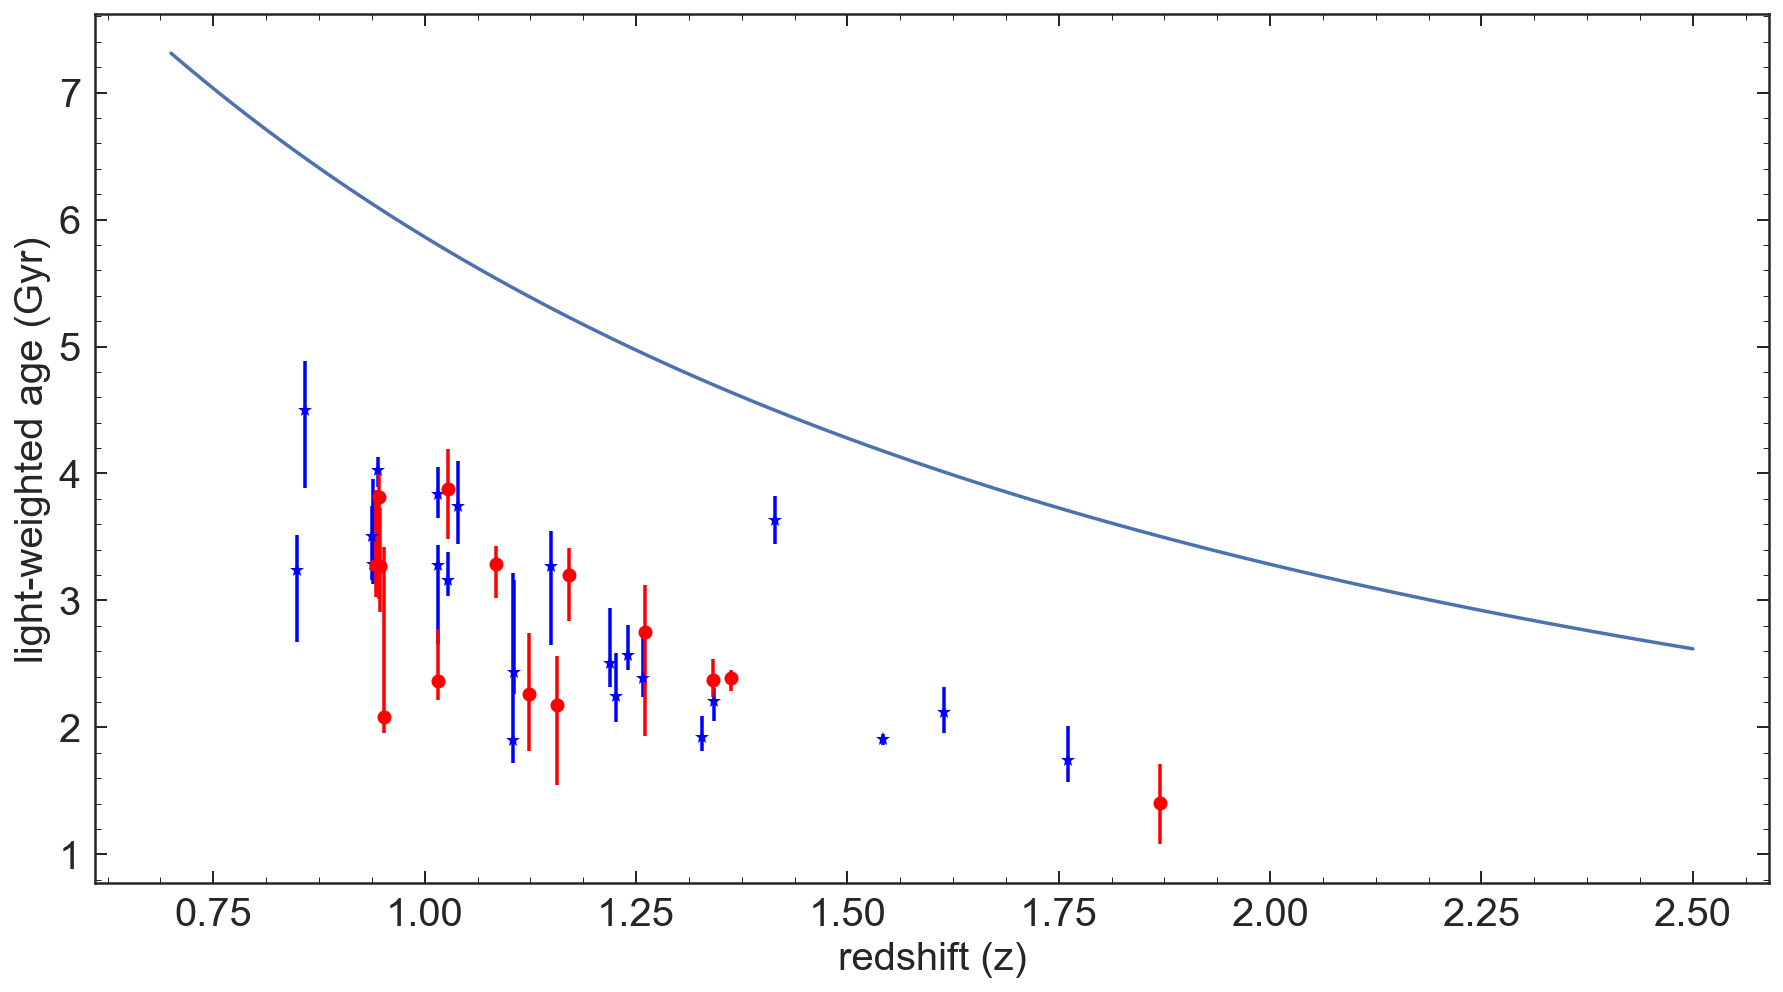

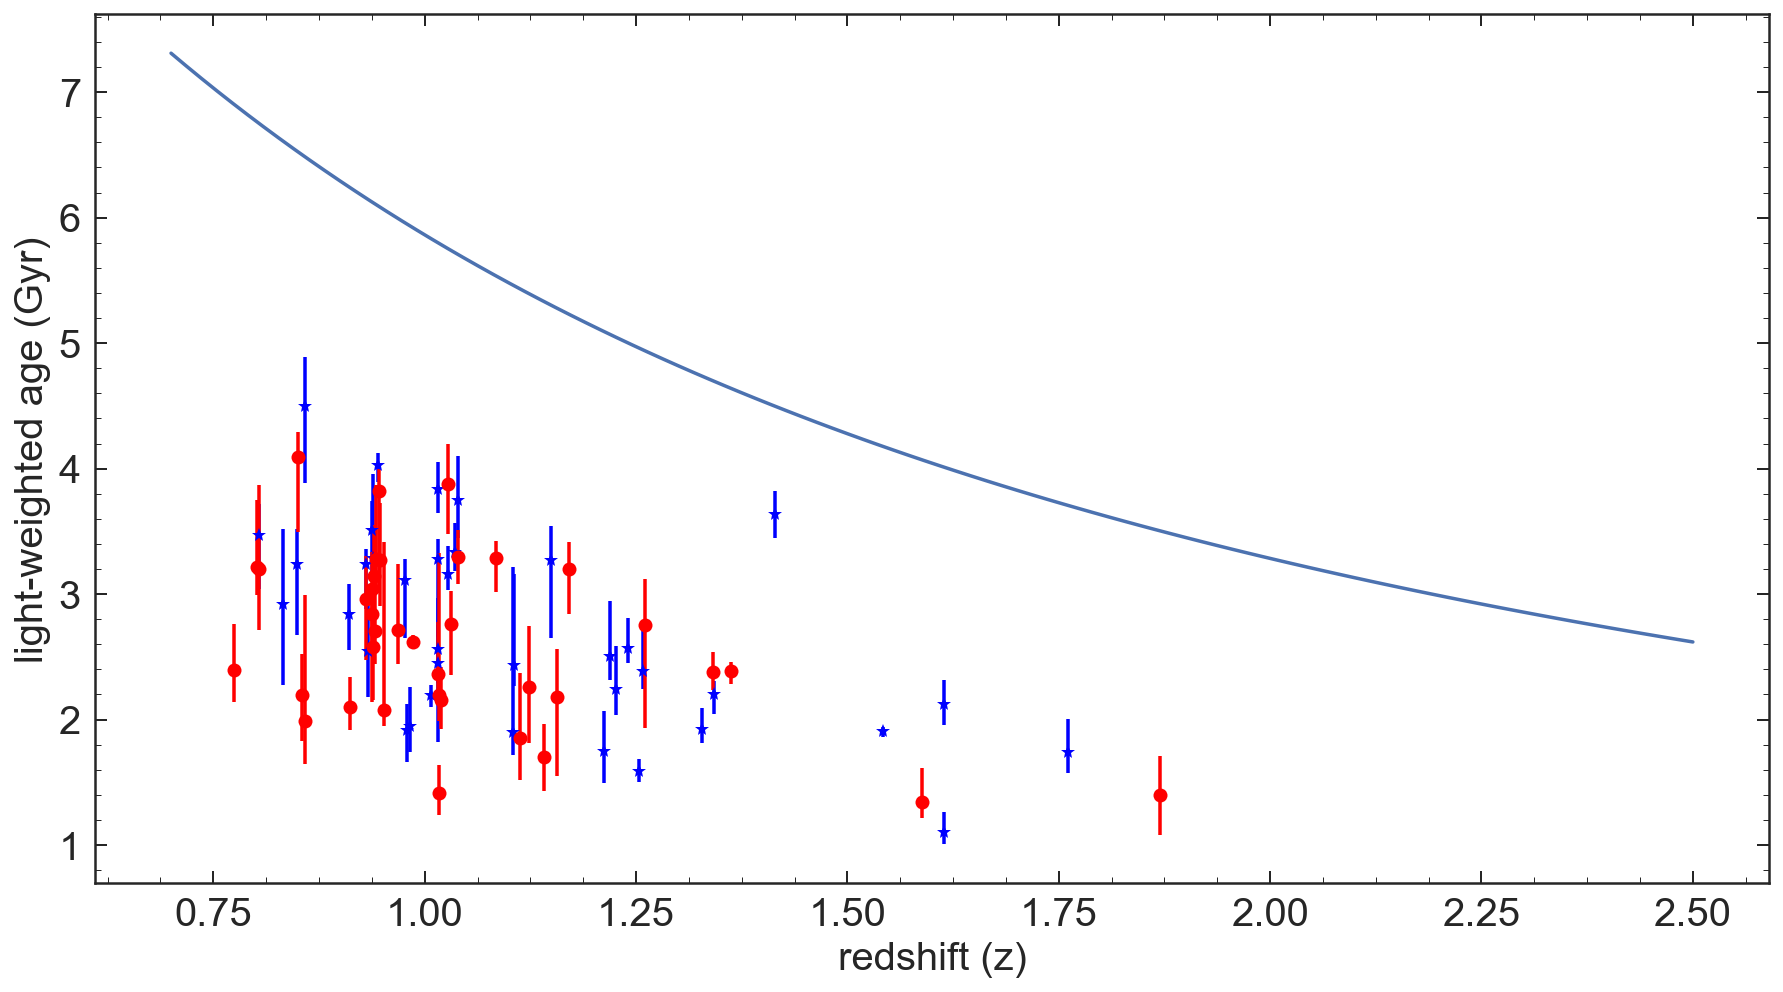

In [108]:
z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

plt.errorbar(mdb.query('compact == "c" and z_50 > 3').z, mdb.query('compact == "c" and z_50 > 3').lwa, 
             yerr=[mdb.query('compact == "c" and z_50 > 3').lwal, mdb.query('compact == "c" and z_50 > 3').lwah],
             fmt='*', color = 'b')


plt.errorbar(mdb.query('compact == "e" and z_50 > 3').z, mdb.query('compact == "e" and z_50 > 3').lwa, 
             yerr=[mdb.query('compact == "e" and z_50 > 3').lwal, mdb.query('compact == "e" and z_50 > 3').lwah],
             fmt='o', color = 'r')

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[15,8])

plt.plot(z,ages)

plt.errorbar(mdb.query('compact == "c" ').z, mdb.query('compact == "c"').lwa, 
             yerr=[mdb.query('compact == "c"').lwal, mdb.query('compact == "c"').lwah],
             fmt='*', color = 'b')


plt.errorbar(mdb.query('compact == "e"').z, mdb.query('compact == "e"').lwa, 
             yerr=[mdb.query('compact == "e"').lwal, mdb.query('compact == "e"').lwah],
             fmt='o', color = 'r')

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)


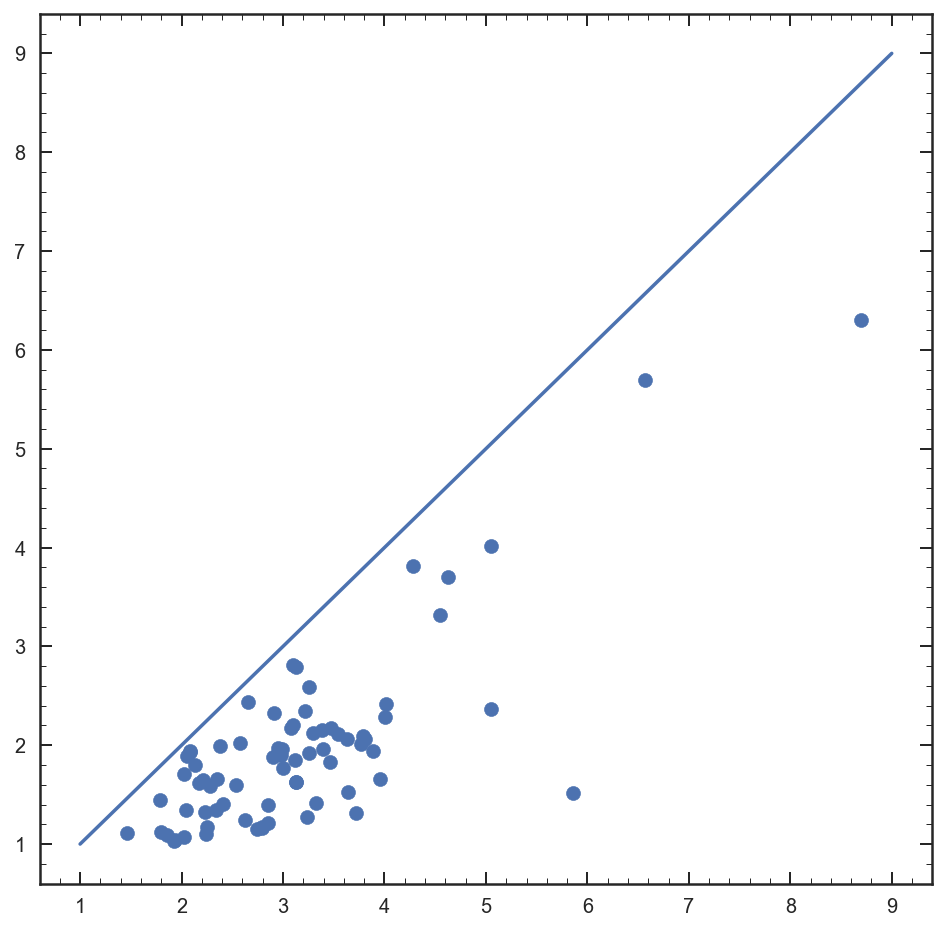

In [101]:
plt.figure(figsize=[8,8])
plt.scatter(mdb.z_50, mdb.z_q)
plt.plot([1,9],[1,9])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


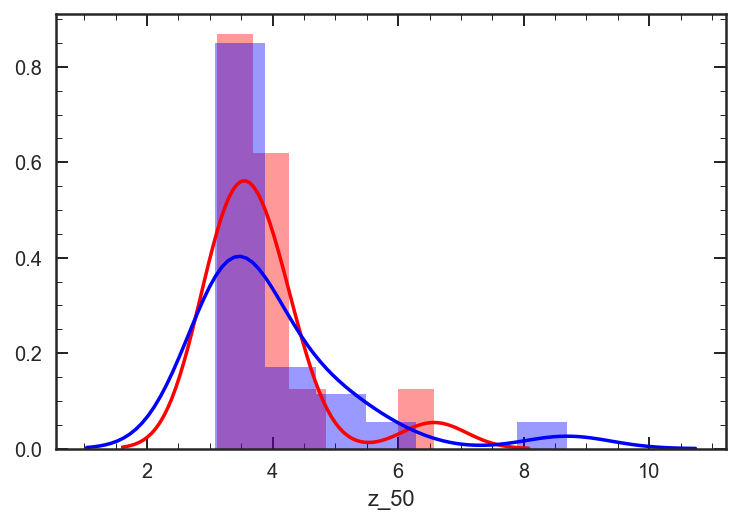

In [97]:
sea.distplot(mdb.query('compact == "e" and z_50 > 3').z_50, color = 'r')
sea.distplot(mdb.query('compact == "c" and z_50 > 3').z_50, color = 'b')

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


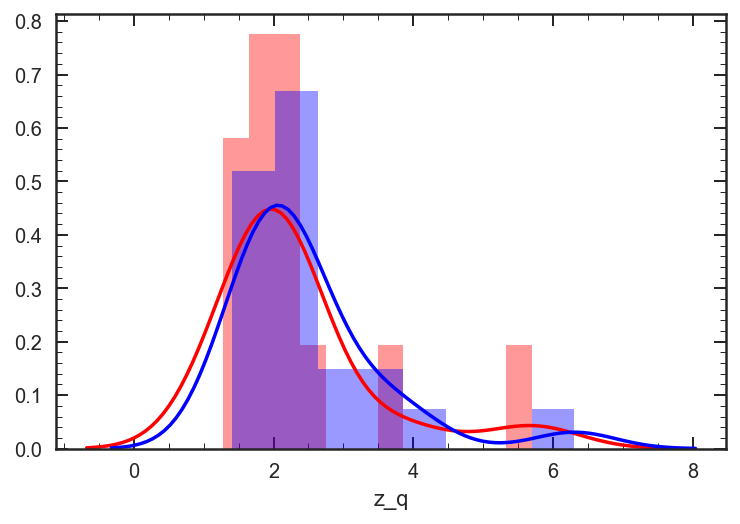

In [100]:
sea.distplot(mdb.query('compact == "e" and z_50 > 3').z_q, color = 'r')
sea.distplot(mdb.query('compact == "c"  and z_50 > 3 ').z_q, color = 'b')

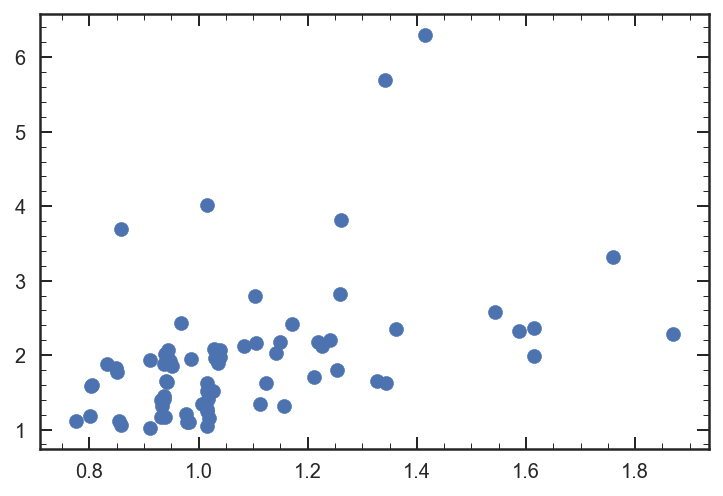

In [109]:
plt.scatter(mdb.z, mdb.z_q)

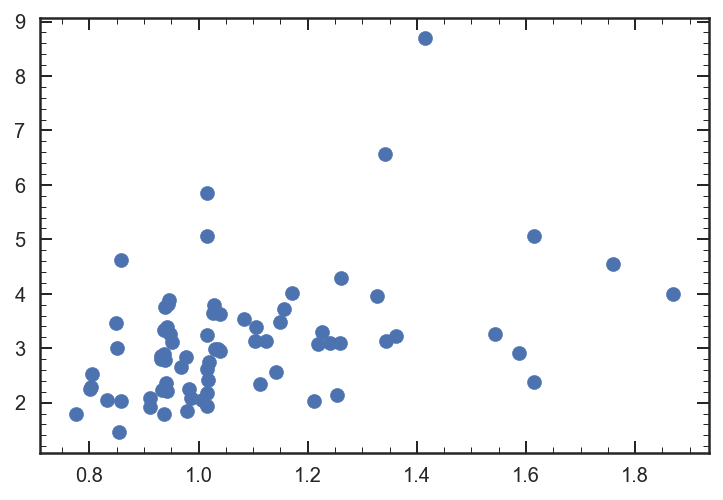

In [110]:
plt.scatter(mdb.z, mdb.z_50)

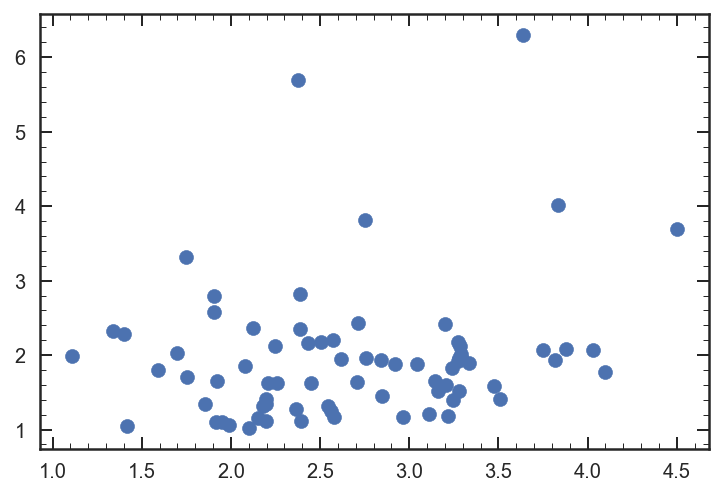

In [111]:
plt.scatter(mdb.lwa, mdb.z_q)

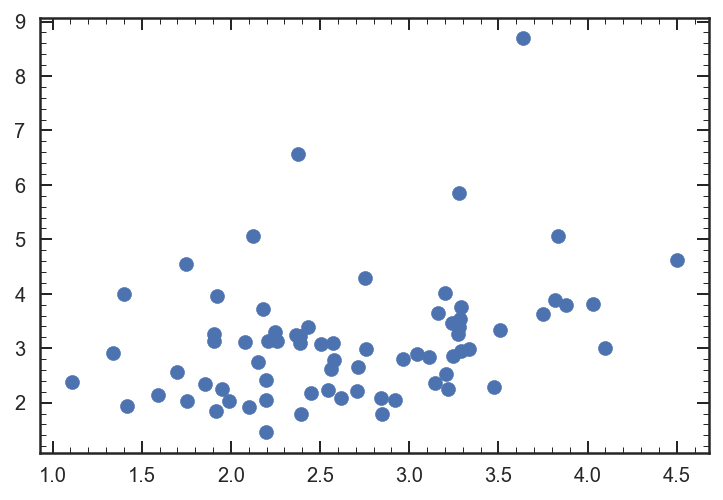

In [112]:
plt.scatter(mdb.lwa, mdb.z_50)

In [114]:
mdb.query('z_50 > 6')

,field,id,Rpc,lm,lml,lmh,z,zl,zh,lwa,lwal,lwah,Reff,AGN,compact,z_q,z_50,sSFR
67,GSD,40623,2.214293,11.035659,0.012475,0.017101,1.414259,0.003409,0.005160,3.636022,0.188355,0.185522,0.255655,---,c,6.303420,8.692207,1.302276e-12
78,GSD,45775,13.672715,11.276962,0.020328,0.016730,1.341257,0.006636,0.005342,2.375735,0.137848,0.159158,1.584806,---,e,5.700317,6.571632,6.424223e-12


In [115]:
morph_db.to_pickle('../dataframes/morphology.pkl')